<a href="https://colab.research.google.com/github/allwin107/SMS-Spam-Detection/blob/main/SMS_Spam_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SMS Spam Detection using TensorFlow in Python**

SMS spam detection is automatically classifying incoming text messages as either ham (legitimate) or spam using machine learning and deep learning models, so that harmful, fraudulent or unwanted messages can be filtered before reaching the user.

In this Notebook, we will:

1. Load and clean an SMS spam dataset and encode labels into numeric form.
2. Prepare text statistics and a text vectorisation pipeline for deep learning models.
3. Build three TensorFlow models, i.e a dense embedding model, a Bi-LSTM model and a transfer-learning model using the Universal Sentence Encoder (USE).
4. Train all models with a shared helper pipeline and evaluate them on accuracy, precision, recall and F1-score.
5. Visualise model performance using bar and line plots to compare metrics.

## **Step 1: Import Libraries**

We will import all the required libraries like numpy, pandas, matplotlib, seaborn, scikit-learn and TensorFlow.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

## **Step 2: Load the Dataset**

We will load the dataset. The used dataset can be downloaded from [here](https://media.geeksforgeeks.org/wp-content/uploads/20240917152755/spam.csv).

In [ ]:
df = pd.read_csv("/content/spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## **Step 3: Clean the dataset and encode labels**

We will clean the dataset:

1. Drops unused columns that contain only null or irrelevant values.
2. Renames columns to more meaningful names i.e label (target) and Text (message).
3. Encodes text labels into numeric form i.e ham is 0 and spam is 1.
4. Shows the cleaned DataFrame with the new encoded label column.


In [ ]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## **Step 4: Split Data and convert to NumPy arrays**

Here,

1. Splits the dataset into training (80%) and testing (20%) sets.
2. Uses a fixed random_state for reproducibility.
3. Converts pandas Series to NumPy arrays.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42
)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

## **Step 5: Compute text Statistics for Vectorization**

Here,

1. Computes the average number of words per SMS, used as sequence length for padding.
2. Estimates vocabulary size by counting unique tokens across all messages.
3. Prints basic dataset statistics for reference.

In [ ]:
avg_words_len = round(sum([len(i.split())
                      for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(X_train_np)}")
print(f"Average words per message: {avg_words_len}")
print(f"Approximate vocabulary size: {total_words_length}")

Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


## **Step 6: Helper functions for training and evaluation**

Here,

1. compile_and_fit centralizes the compile + train logic for all models.
2. Uses binary_crossentropy and accuracy for binary classification.
3. Trains on training data and validates on the test data, returning training history.
4. get_metrics predicts labels, rounds probabilities to 0 or 1 and computes accuracy, precision, recall and F1-score.

In [ ]:
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=epochs,
        validation_data=(X_test_np, y_test_np)
    )
    return history

def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1-score': f1_score(y, y_preds)
    }

## **Step 7: Create the TextVectorization layer**

Here,

1. Creates a TextVectorization layer to convert raw text into integer sequences.
2. Limits the vocabulary size to total_words_length unique words.
3. Standardizes text by lowercasing and stripping punctuation.
4. Pads or truncates each sequence to avg_words_len tokens.
5. Adapts the layer on training data to learn the vocabulary distribution.

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)
text_vec.adapt(X_train_np)

## **Step 8: Model 1 – Dense embedding model (build and train)**

Here,

1. Defines an input layer that expects string tensors.
2. Applies the TextVectorization layer to convert text into token IDs.
3. Uses an Embedding layer to learn dense vector representations for each word.
4. Applies GlobalAveragePooling1D to compress each sequence into a single vector.
5. Adds a dense hidden layer with ReLU activation for non-linearity.
6. Outputs a single sigmoid unit for binary spam/ham prediction.
7. Compiles and trains the model using the shared compile_and_fit function.

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name="Dense_Model")
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8431 - loss: 0.4258 - val_accuracy: 0.9596 - val_loss: 0.1525
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9774 - loss: 0.1052 - val_accuracy: 0.9749 - val_loss: 0.0807
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9878 - loss: 0.0532 - val_accuracy: 0.9767 - val_loss: 0.0670
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9927 - loss: 0.0285 - val_accuracy: 0.9776 - val_loss: 0.0677
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9961 - loss: 0.0200 - val_accuracy: 0.9785 - val_loss: 0.0652


## **Step 9: Model 2 – Bidirectional LSTM model (build and train)**

Here,

1. Uses the same input and text vectorization setup as Model 1.
2. Adds an embedding layer to convert token IDs into dense vectors.
3. Stacks two Bidirectional LSTM layers to capture context from both past and future tokens.
4. Flattens the final sequence output before feeding into dense layers.
5. Adds dropout to reduce overfitting.
6. Uses a dense hidden layer with ReLU and a sigmoid output layer for classification.
7. Compiles and trains this Bi-LSTM model with the helper function.

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name="BiLSTM_Model")
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.9051 - loss: 0.2920 - val_accuracy: 0.9749 - val_loss: 0.0846
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.9886 - loss: 0.0438 - val_accuracy: 0.9848 - val_loss: 0.0628
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 0.9776 - val_loss: 0.0834
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9740 - val_loss: 0.1032
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9987 - loss: 0.0023 - val_accuracy: 0.9785 - val_loss: 0.1474


## **Step 10: Model 3 – Transfer learning with Universal Sentence Encoder (build and train)**

Here,

1. Loads the pre-trained Universal Sentence Encoder from TensorFlow Hub.
2. Freezes the USE layer (trainable=False) to use it purely as a feature extractor.
3. Defines an input layer with scalar string input (shape=[]) as expected by USE.
4. Uses a Lambda layer to call USE and produce a fixed 512-dimensional sentence embedding.
5. Adds a dense hidden layer with 64 units and ReLU activation.
6. Uses dropout for regularization.
7. Outputs a single sigmoid unit for spam vs ham prediction.
8. Compiles and trains the USE-based transfer learning model with the same pipeline.

In [ ]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(
    x), output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(input_layer, output_layer, name="USE_Model")
history_3 = compile_and_fit(model_3)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8658 - loss: 0.4567 - val_accuracy: 0.9731 - val_loss: 0.1124
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9765 - loss: 0.0941 - val_accuracy: 0.9776 - val_loss: 0.0702
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9871 - loss: 0.0487 - val_accuracy: 0.9821 - val_loss: 0.0587
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9873 - loss: 0.0452 - val_accuracy: 0.9857 - val_loss: 0.0544
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9915 - loss: 0.0354 - val_accuracy: 0.9848 - val_loss: 0.0532


## **Step 11: Collect performance metrics for all models**

Here,

1. Evaluates each model on the same test set using the get_metrics helper.
2. Builds a DataFrame summarizing accuracy, precision, recall and F1-score for all models.
3. Prints a performance table for quick numeric comparison.

In [ ]:
results = {
    'Dense Embedding': get_metrics(model_1, X_test_np, y_test_np),
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print("Performance Table:")
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Performance Table:
                         accuracy  precision    recall  f1-score
Dense Embedding          0.978475   0.962963  0.872483  0.915493
Bi-LSTM                  0.978475   0.977099  0.859060  0.914286
Transfer Learning (USE)  0.984753   0.964789  0.919463  0.941581


The table compares the performance of all three models on the same dataset:

* Transfer Learning (USE) gives the highest overall score, especially in recall and F1-score, showing it captures patterns more effectively.
* Bi-LSTM also performs slightly better than Dense Embedding because it understands sequence information.

## **Step 12: Visualize**

We will visualize the results,

**a. Bar Chart**

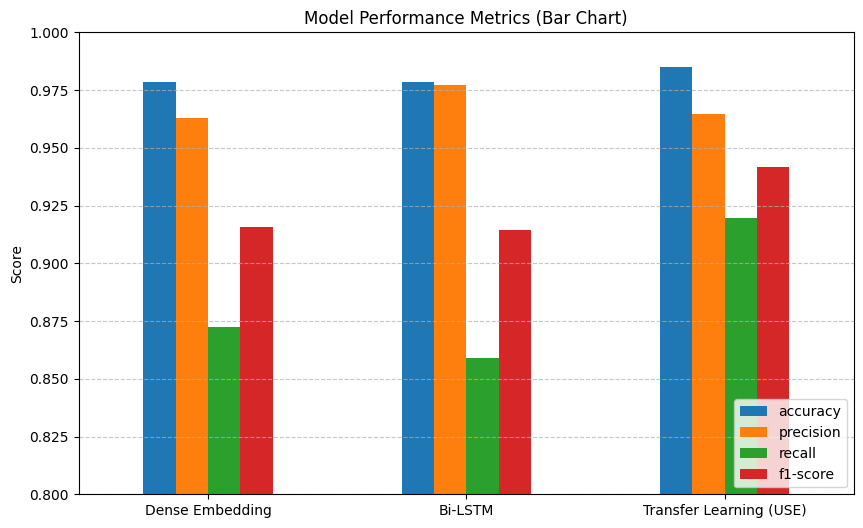

In [ ]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**b. Line Graph**

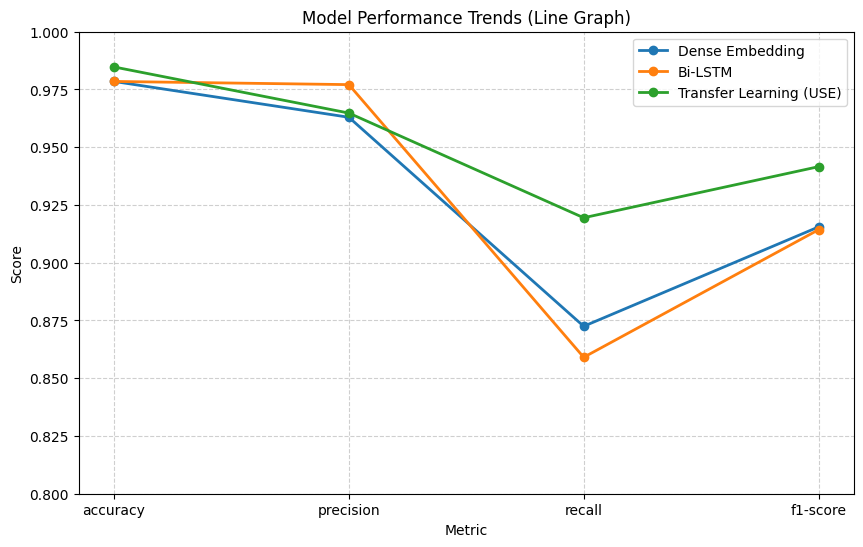

In [ ]:
plt.figure(figsize=(10, 6))

for model_name in results_df.index:
    plt.plot(
        results_df.columns,
        results_df.loc[model_name],
        marker='o',
        label=model_name,
        linewidth=2
    )
plt.title("Model Performance Trends (Line Graph)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()